In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from sqlalchemy import create_engine
import time
from datetime import date, timedelta

engine = create_engine('postgresql://michaelbecker@localhost:5432/spotdb')

In [4]:
c = engine.connect()

In [5]:
#Change zone when running a new model

sql_str = "SELECT date_time, price FROM all_spot WHERE zone='us-west-2c' AND type='c3.2xlarge' AND os='Linux/UNIX (Amazon VPC)';"
print sql_str

SELECT date_time, price FROM all_spot WHERE zone='us-west-2c' AND type='c3.2xlarge' AND os='Linux/UNIX (Amazon VPC)';


In [6]:
df = pd.read_sql(sql_str, c)

In [7]:
print df.head()
print df.dtypes

             date_time   price
0  2015-07-01 06:09:11  0.0673
1  2015-07-01 06:14:05  0.0676
2  2015-07-01 06:24:09  0.0670
3  2015-07-01 06:34:08  0.0669
4  2015-07-01 06:39:00  0.0667
date_time     object
price        float64
dtype: object


In [8]:
#Change 'date_time' to a datetime type
df['date_time'] = df['date_time'].apply(lambda x: pd.to_datetime(x))

In [9]:
print df.head()
print df.dtypes
print df.shape

            date_time   price
0 2015-07-01 06:09:11  0.0673
1 2015-07-01 06:14:05  0.0676
2 2015-07-01 06:24:09  0.0670
3 2015-07-01 06:34:08  0.0669
4 2015-07-01 06:39:00  0.0667
date_time    datetime64[ns]
price               float64
dtype: object
(77938, 2)


In [10]:
#Make 'date_time' the index
df = df.set_index('date_time')

In [11]:
df.index

DatetimeIndex(['2015-07-01 06:09:11', '2015-07-01 06:14:05',
               '2015-07-01 06:24:09', '2015-07-01 06:34:08',
               '2015-07-01 06:39:00', '2015-07-01 06:43:53',
               '2015-07-01 06:48:55', '2015-07-01 07:13:40',
               '2015-07-01 07:28:35', '2015-07-01 07:33:30',
               ...
               '2017-02-11 23:11:02', '2017-02-11 23:23:02',
               '2017-02-11 23:30:17', '2017-02-11 23:37:02',
               '2017-02-11 23:39:42', '2017-02-11 23:48:17',
               '2017-02-11 23:49:08', '2017-02-12 00:01:05',
               '2017-02-12 00:08:02', '2017-02-12 00:24:44'],
              dtype='datetime64[ns]', name=u'date_time', length=77938, freq=None)

In [12]:
#Make sure the index is sorted apporpriately
df = df.sort_index()

In [13]:
df.index.is_monotonic_increasing

True

In [14]:
print df.head()

                     price
date_time                 
2013-11-14 16:48:58  0.203
2013-11-15 05:33:34  0.250
2013-11-15 07:18:36  0.203
2013-11-15 12:51:39  0.400
2013-11-15 18:45:55  0.203


In [15]:
#resample method = performs a frequency conversion of time series data, resampling it to constant intervals
#pad method = forward fills the data to the next change
#http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

prod = df.resample('W').pad()

In [16]:
prod.price.describe()


count    170.000000
mean       0.171987
std        0.324691
min        0.064100
25%        0.066425
50%        0.072050
75%        0.094900
max        2.400000
Name: price, dtype: float64

In [17]:
prod.price.head()


date_time
2013-11-17    0.260
2013-11-24    0.128
2013-12-01    0.159
2013-12-08    1.500
2013-12-15    0.301
Freq: W-SUN, Name: price, dtype: float64

In [57]:
from statsmodels.tsa.stattools import adfuller

#The null hypoithesis is that the data is time dependent (non-stationary)
#The test stat is signifficantly lower than the critical values, meaning we can reject the null and our data is stationary
#No need to to take log of

X = prod.price
result = adfuller(X, 1) #max lag of 1
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.102948
p-value: 0.000014
Critical Values:
	5%: -2.930
	1%: -3.589
	10%: -2.603


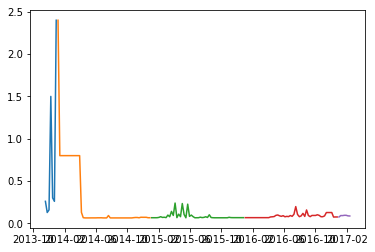

In [19]:
###Graph of prices taking the weekly mean... still no visual of non-stationarity


print plt.plot(prod.price['2013'])
print plt.plot(prod.price['2014'])
print plt.plot(prod.price['2015'])
print plt.plot(prod.price['2016'])
print plt.plot(prod.price['2017'])
#There appears to have no trend but large spikes suggesting an MA model would be most effective
#Additionally, there appears to be a right skew in the price distribution given the large spikes with flat lines between
#Take square root of the prices to negate the spikes (right skew)
#Also, there might be some seasonality with spikes after/around 1st quarter of year and more so at mid year
#shrink down to find trends

In [20]:
#Started with 5 minute resampling but there was zero relationships to be seen
#The weekly data is the shortest period when we start seeing a measurable relationship
#Moving forward with the weekldata for this specific availibility zone

data = df.resample('W').pad()
train = data.price[:'2016-11-29']
test = data.price['2016-11-30':]

In [21]:
print data.shape
print train.shape
print test.shape

(170, 1)
(159,)
(11,)


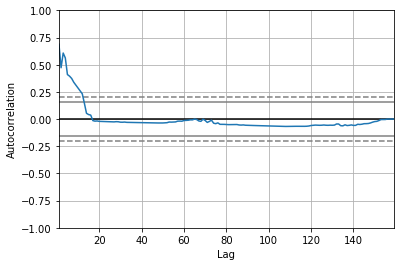

In [22]:
pd.tools.plotting.autocorrelation_plot(train)


In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


Figure(432x288)


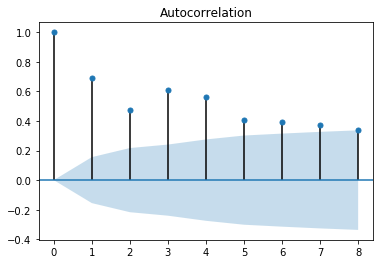

In [26]:
print plot_acf(train, lags=8)
#Helps determine 'q'

Figure(432x288)


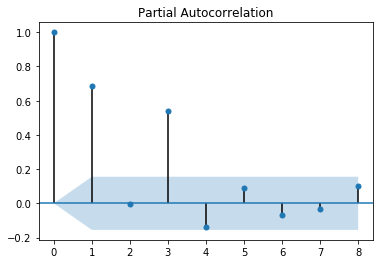

In [27]:
print plot_pacf(train, lags=8)
#helps determine 'p'

In [67]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train, (2, 0, 5)).fit()
#us_west_2b order = 4,0,2 
#us_west_2a order = 3,0,0
#us_west_2c order = 4,0,2

/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [68]:
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  price   No. Observations:                  159
Model:                     ARMA(2, 5)   Log Likelihood                  37.138
Method:                       css-mle   S.D. of innovations              0.186
Date:                Thu, 04 May 2017   AIC                            -56.275
Time:                        10:59:57   BIC                            -28.655
Sample:                    11-17-2013   HQIC                           -45.059
                         - 11-27-2016                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           0.1821      0.094      1.941      0.054        -0.002     0.366
ar.L1.price     1.4427      0.137     10.532      0.000         1.174     1.711
ar.L2.price    -0.4666      0.104     -4.484    

Figure(432x288)


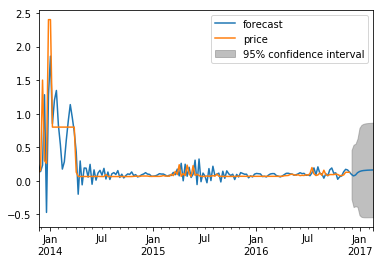

In [69]:

figure = model.plot_predict(1, 170)
print figure

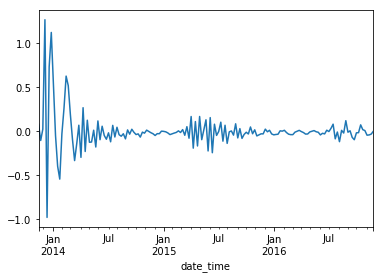

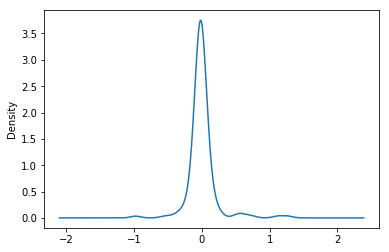

count    159.000000
mean      -0.000371
std        0.209121
min       -0.980768
25%       -0.046024
50%       -0.017547
75%        0.012188
max        1.265370
dtype: float64


In [70]:
residuals = model.resid
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Figure(432x288)
Figure(432x288)


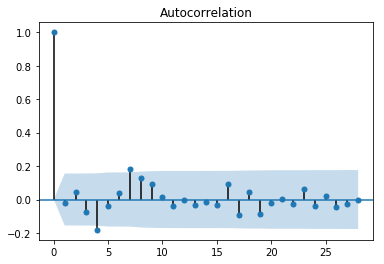

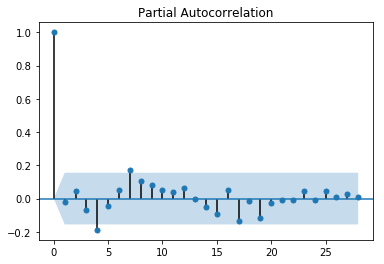

In [71]:

print plot_acf(model.resid, lags=28)
#Decays to zero and hugs the line, suggesting residuals are not correlated
print plot_pacf(model.resid, lags=28)

In [72]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [74]:
history = [x for x in train] #takes train and builds a model, then appends the 'obs' to roll history onwards
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,0,5)) #model is called with params of above
    model_fit = model.fit(disp=0) #model is fit just as above
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
error1 = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % error**(0.5))
print('Test MAE: %.3f' % error1)

/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.093814, expected=0.127700


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.098669, expected=0.074300


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.069339, expected=0.075300


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.142221, expected=0.075300


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.109141, expected=0.075300


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.111725, expected=0.092100


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.100905, expected=0.091500


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.056357, expected=0.095000


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.102394, expected=0.095000


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=0.088882, expected=0.088300
predicted=0.134317, expected=0.086900
Test MSE: 0.001
Test RMSE: 0.033
Test MAE: 0.026


/Users/michaelbecker/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


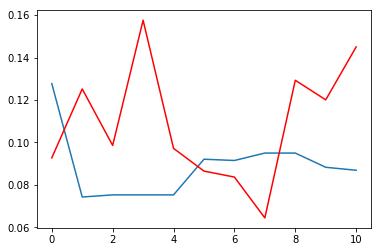

In [52]:
plt.plot(list(test))
plt.plot(predictions, color='red')
plt.show()